# Checker

In [1]:
import tensorflow as tf
import numpy as np

# Проверка наличия GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

# Создание простой модели
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Создание случайных данных для обучения
x_train = np.random.rand(100, 28, 28)
y_train = np.random.randint(10, size=(100,))

# Обучение модели
model.fit(x_train, y_train, epochs=5, batch_size=16)
print("GPU is being used:", tf.test.is_gpu_available())


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/5
7/7 [==============================] - 1s 3ms/step - loss: 2.4840 - accuracy: 0.0800
Epoch 2/5
7/7 [==============================] - 0s 3ms/step - loss: 2.2023 - accuracy: 0.1400
Epoch 3/5
7/7 [==============================] - 0s 3ms/step - loss: 2.0851 - accuracy: 0.4100
Epoch 4/5
7/7 [==============================] - 0s 3ms/step - loss: 1.9667 - accuracy: 0.3700
Epoch 5/5
7/7 [==============================] - 0s 3ms/step - loss: 1.8256 - accuracy: 0.4100
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is being used: True


# Packages

In [2]:
from matplotlib import pyplot

from numpy import hstack, zeros, ones
from numpy.random import rand, randn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


---

## Цель:
### Создать генеративную нейронную сеть, способную генерировать наборы точек (x, y), которые удовлетворяют уравнению параболы y=x^2
*(формально, просто ТОЧКУ, которая принадлежит некоторой функции)*

## Входные данные:
### - Функция параболы y=x^2
### - Признаки: x1 и x2 - координаты точки на плоскости, однозначно задающие ее положение. x1 = x; x2 = y

---

# Предистроия

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Ian_Goodfellow.jpg/1024px-Ian_Goodfellow.jpg)

# https://en.wikipedia.org/wiki/Ian_Goodfellow

## Прочий сурс
- https://scholar.google.ca/citations?user=iYN86KEAAAAJ
- https://www.deeplearningbook.org/
- https://arxiv.org/abs/1406.2661

# Теория и структура GAN

Генеративно-состязательная сеть (Generative Adversarial Networks) состоит из двух частей:

- **Генератор** учится генерировать правдоподобные данные. Сгенерированные экземпляры становятся отрицательными обучающими примерами для *дискриминатора*.
- **Дискриминатор** учится отличать поддельные данные *генератора* от реальных данных. Дискриминатор наказывает генератор за неправдоподобные результаты.

![title](https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg?hl=ru)

![title](https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg?hl=ru)

![title](https://developers.google.com/static/machine-learning/gan/images/good_gan.svg?hl=ru)

# Устройство дискриминатора

**Дискриминатор** по сути является обычным классификатором, который берет данные из двух источников: из *генератора* (эти данные будут поставляться в него с меткой **0**) и из *реальных данных* (эти данные будут помечены меткой **1**). Т.к. Дискриминатор классифицирует изображения, то у него на выходе (в самом простом случае) только один выход.

# Устройство генератора

**Генератор** - это нейронная сеть, генерирующая данные, а нейронным сетям нужна какая-то форма ввода. Обычно мы вводим данные, с которыми хотим что-то сделать, например экземпляр, который хотим классифицировать или сделать прогноз, но в данном случае, мы хотим *создать* признаки. А создаются они из шума. Эксперименты показывают, что распределение шума не имеет большого значения, поэтому мы можем выбрать что-то, из чего легко сделать выборку, например равномерное распределение. Для удобства пространство, из которого сэмплируется шум, обычно имеет меньшую размерность, чем размерность выходного пространства.

# Discriminator part

In [3]:
def define_discriminator(n_inputs=2):
    # Sequential - класс, который позволяет создать модель путем добавления слоев последовательно, от входного до выходного.
    # Каждый следующий слой принимает на вход выход предыдущего слоя, это простой способ построения сетей, 
    # когда не нужно создавать сложные архитектуры с параллельными ветвями и многовходовыми или многовыходовыми компонентами.
    model = Sequential()

    # По умолчанию на входе 2 признака (n_inputs), они связываются с 25 нейронами (первый скрытый слой)
    # Эти 25 нейронов в качестве функции активации используют relu (Можно, конечно, использовать и другие известные функции:
    # sigmoid, softmax, leaky_relu и другие. Причем задавать функцию активации можно не только через аргумент в слое,
    # но и через специальный класс Activation, а еще можно писать собственные функции активации, как в примере ниже. 
    # Подробнее: https://keras.io/api/layers/activations/#sigmoid-function).
    # А еще веса инициализированы равномерно (и чуть модифицировано, чем просто uniform), можно инициализировать нормально, нулями,
    # единицами и прочее прочее ( https://keras.io/api/layers/initializers/#randomnormal-class ).
    model.add(Dense(25, input_dim=n_inputs, activation='relu', kernel_initializer='he_uniform'))

    # После докидываем выходной слой с одним нейроном, который будем говорить нам 'вероятность' принадлежности точки к заданной функции.
    model.add(Dense(1, activation='sigmoid'))

    # Дособираем модель, задав функцию потерь, алгоритм оптимизации и метрику, с помощью которой будем отслеживать качество модели.
    # Про функции потерь: https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    # Про алгоритмы оптимизации: https://keras.io/api/optimizers/
    # Про метрики: https://keras.io/api/metrics/
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


def define_discriminator_custom(n_inputs=2):
    # Зададим собственную функцию активации
    def custom_activation(x):
        # leaky x^3 :)
        return tf.where(x > 0, x**3, -0.1 * x)

    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, activation=custom_activation, kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [4]:
discriminator = define_discriminator()
print(discriminator.weights)
print('-' * 80)
print(discriminator.summary())
print('-' * 80)
print(discriminator.layers)
print('-' * 80)
print(discriminator.layers[0].activation, discriminator.layers[1].activation)


[<tf.Variable 'dense_2/kernel:0' shape=(2, 25) dtype=float32, numpy=
array([[ 1.4179364 , -0.48797846,  0.5411824 ,  0.01242983,  0.9269198 ,
         0.929778  , -0.24696743, -0.03429496,  0.2580936 ,  0.13999939,
        -1.0277015 , -1.0993752 ,  1.4408916 ,  1.4751164 ,  1.5312561 ,
         1.0214943 , -0.20597029,  0.11075819,  1.660901  , -0.64006984,
        -1.5384893 , -0.01608086,  0.26489413,  1.2425417 , -1.4676147 ],
       [-1.4667445 , -1.4277102 ,  0.5433191 ,  1.0945174 ,  0.48548424,
        -0.7558429 ,  0.2964214 ,  1.3917338 ,  1.0558058 ,  1.1090866 ,
        -0.7576537 , -0.5187975 ,  0.26912987, -1.3133328 , -0.32810283,
        -0.9077254 , -0.5331534 ,  0.39615786, -1.1412978 , -1.4486027 ,
         0.6973051 , -0.46550095,  0.8807169 ,  0.6951417 ,  0.05557644]],
      dtype=float32)>, <tf.Variable 'dense_2/bias:0' shape=(25,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0

In [5]:
discriminator_custom = define_discriminator_custom()
print(discriminator_custom.weights)
print('-' * 80)
print(discriminator_custom.summary())
print('-' * 80)
print(discriminator_custom.layers)
print('-' * 80)
print(discriminator_custom.layers[0].activation, discriminator_custom.layers[1].activation)


[<tf.Variable 'dense_4/kernel:0' shape=(2, 20) dtype=float32, numpy=
array([[ 1.5952903 ,  1.405322  , -1.4280677 ,  0.5894612 ,  0.83356726,
         0.6189877 , -1.2627106 , -1.7092587 ,  1.2211972 ,  0.65195787,
         0.5595635 ,  0.37547886, -0.38468647, -1.0948018 , -0.5863645 ,
         0.51902497, -1.1035465 , -1.0866084 , -0.7914436 , -1.322932  ],
       [-0.9258743 ,  1.716287  , -1.3028451 ,  1.2078484 , -0.28559542,
         0.96576583, -1.0201964 , -0.91155636,  0.7639309 ,  1.3141109 ,
         1.5645293 , -1.3046216 ,  1.1493505 , -1.1303649 , -1.3145221 ,
         1.1826452 ,  1.2588524 , -0.6292356 ,  0.2501558 , -1.2434807 ]],
      dtype=float32)>, <tf.Variable 'dense_4/bias:0' shape=(20,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>, <tf.Variable 'dense_5/kernel:0' shape=(20, 1) dtype=float32, numpy=
array([[ 0.18104964],
       [ 0.46245587],
       [-0.39600056],
       [-0.

# Generator part

In [6]:
def define_generator(latent_dim=1, n_outputs=2):
    model = Sequential()

    # На входе у генератора признаки из латентного пространства (с низкой размерностью)
    model.add(Dense(20, activation='leaky_relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(20, activation='leaky_relu', kernel_initializer='he_uniform'))
    model.add(Dense(n_outputs, activation='linear'))
    return model

def define_generator_custom(latent_dim=1, n_outputs=2):
    def custom_activation(x):
        # припущенная сигмоида
        return 8 * (tf.nn.sigmoid(x) - 0.5)
    
    model = Sequential()
    model.add(Dense(16, activation='leaky_relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(8, activation='leaky_relu', kernel_initializer='he_uniform'))
    model.add(Dense(n_outputs, activation=custom_activation))
    return model
    

In [7]:
generator = define_generator()
print(generator.weights)
print('-' * 80)
print(generator.summary())
print('-' * 80)
print(generator.layers)


[<tf.Variable 'dense_6/kernel:0' shape=(1, 20) dtype=float32, numpy=
array([[ 0.3369305 , -0.7998961 , -0.7886646 ,  1.5403061 , -2.176343  ,
         1.297965  , -2.2346308 ,  1.6783564 , -1.1258923 ,  2.0158956 ,
         0.24541593,  1.5801451 , -1.971482  , -0.8759959 ,  0.78879833,
        -2.2163863 ,  1.57461   ,  0.14079642,  1.8646667 ,  0.7009449 ]],
      dtype=float32)>, <tf.Variable 'dense_6/bias:0' shape=(20,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>, <tf.Variable 'dense_7/kernel:0' shape=(20, 20) dtype=float32, numpy=
array([[-0.10942441, -0.20785937,  0.28949648,  0.46437073,  0.06556588,
        -0.41897428,  0.27161205,  0.05041111,  0.48160875, -0.5135    ,
         0.17431349,  0.28259838, -0.39605165,  0.54207134,  0.35626692,
         0.08079249, -0.23534316, -0.522467  , -0.39731193,  0.5429685 ],
       [ 0.18211734,  0.04941058, -0.40615672,  0.18061233, -0.19604567,
   

---

In [8]:
def define_gan(generator, discriminator):
    # Зафиксируем веса дискриминатора, чтобы можно было тренировать генератор.
    discriminator.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model


# Ручками генерируем реальные данные (реальные точки, удовлетворяющие функции y=x^2).
def generate_real_samples(n):
    # Равномерное распределение икса на отрезке [-2, 2].
    X1 = 4 * rand(n) - 2
    # Соответсвующий иксам игрек для функции y=x^2.
    X2 = X1 * X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    
    # Т.к. эти точки НАСТОЯЩИЕ, у них будет метка 1 для дискриминатора.
    y = ones((n, 1))
    
    return X, y


# Генерируем шум (n раз для генерации n точек у генератора в дальнейшем).
def generate_latent_points(latent_dim, n):
    # Стандартное нормальное распределние.
    x_input = randn(latent_dim * n)
    # Из-за того, что на вход можно подать любую размерность латентого пространства, надо порешейпить шум.
    # n строк для n точек.
    x_input = x_input.reshape(n, latent_dim)
    return x_input


# Просим генератор сгенерировать данные (n точек, где каждая точка определяется ДВУМЯ коордианатми) из случайного шума.
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input, verbose=0)
    
    # Т.к. эти точки СГЕНЕРИРОВАННЫЕ, у них будет метка 0 для дискриминатора
    y = zeros((n, 1))
    
    return X, y


# В сухом остатке генеративная состязательная сеть выглядит так:

![title](../pics/full_gan.png)

In [9]:
# Вспомогательная функция для отслеживания прогресса обучения.
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100, plot=False):
    
    # Оцениваем дискриминатор на РЕАЛЬНЫХ данных.
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Оцениваем дискриминатор на ФЕЙКОВЫХ данных.
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    if plot:
        # Выводим сводную информацию по обучению.
        print(epoch, round(acc_real, 4), round(acc_fake, 4))
        
        # Рисуем картиночки, какие реальные данные попали на вход к дискриминатору (красные точечки),
        # и какие фейковые данные попали к нему (синие точечки).
        pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
        pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
        pyplot.show()
        
    return epoch, round(acc_real, 4), round(acc_fake, 4)
    

# Обучение ГАНа.
def train(generator, discriminator, gan_model, latent_dim, n_epochs=4000, n_batch=256, n_eval=400):
    
    half_batch = n_batch // 2
    accuracies_real = []
    accuracies_fake = []
    g_losses = []
    d_losses = []
    
    for i in range(n_epochs + 1):
        # Генерируем реальные и фейковые наборы данных.
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        X_to_disc = np.vstack([x_real, x_fake])
        y_to_disc = np.vstack([y_real, y_fake])
        # Пошафлим строки, потому что можем.
        all_data = np.hstack([X_to_disc, y_to_disc])
        np.random.shuffle(all_data)
        X_to_disc, y_to_disc = all_data[:, :2], all_data[:, 2:]
        
        # Поучим исключительно дискриминатор.
        d_loss = discriminator.train_on_batch(X_to_disc, y_to_disc)
        
        # Приготовим точки из латентного пространства, для подачи их в генератор
        x_to_gan = generate_latent_points(latent_dim, n_batch)
        y_to_gan = ones((n_batch, 1))
        
        # Поучим генератор выдавать экземлпяры, похожие на реальные данные.
        # Не забываем что здесь это возможно, из-за того что веса дискриминатора зафиксированы! (discriminator.trainable = False)
        g_loss = gan_model.train_on_batch(x_to_gan, y_to_gan)
        
        # Будем рисовать графичек для ГАНа каждые n_eval эпох
        epoch, acc_real, acc_fake = summarize_performance(i, generator, discriminator, latent_dim, plot=(i % n_eval == 0))
        
        accuracies_real.append(acc_real)
        accuracies_fake.append(acc_fake)
        g_losses.append(g_loss)
        d_losses.append(d_loss)
        
    return accuracies_real, accuracies_real, g_losses, d_losses


# Идем учиться

0 0.99 0.02


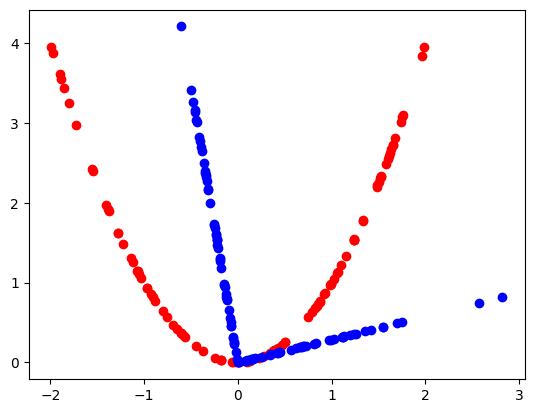

250 0.67 0.14


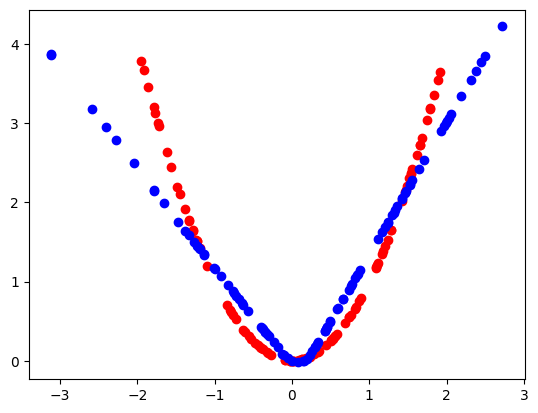

500 0.73 0.11


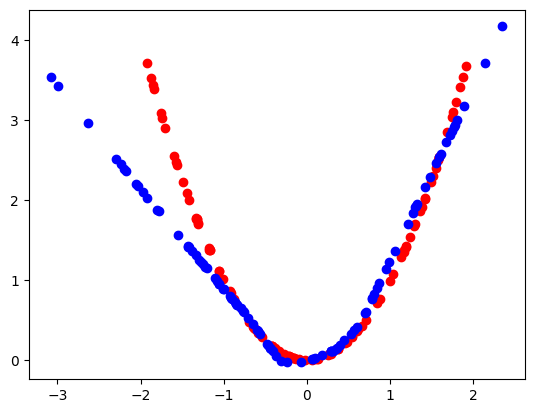

750 0.78 0.36


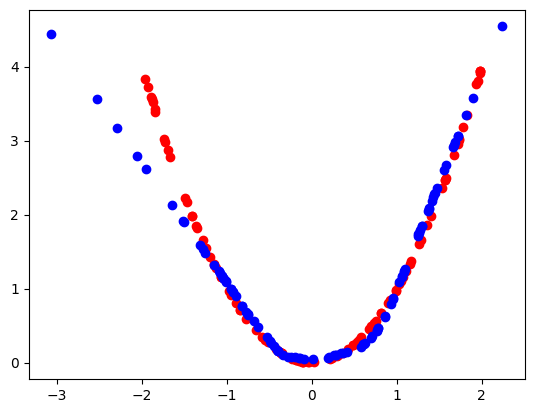

1000 0.74 0.25


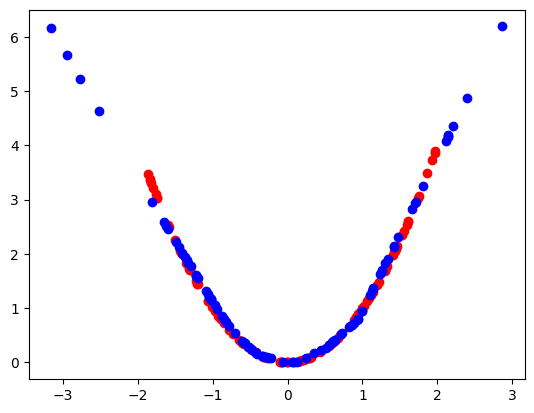

1250 0.46 0.47


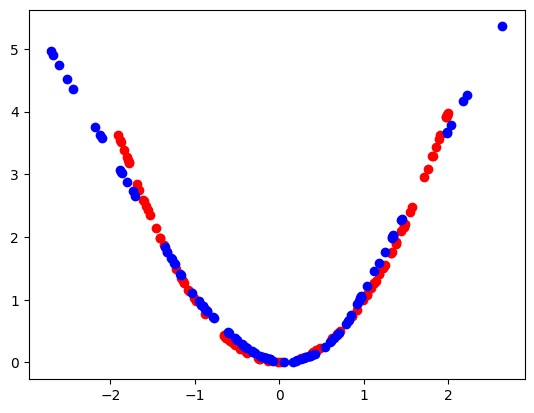

1500 0.57 0.44


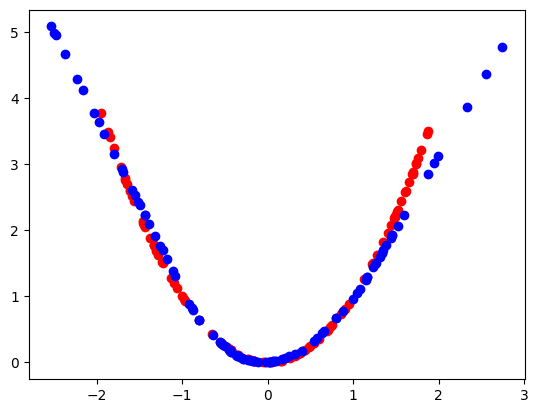

1750 0.95 0.14


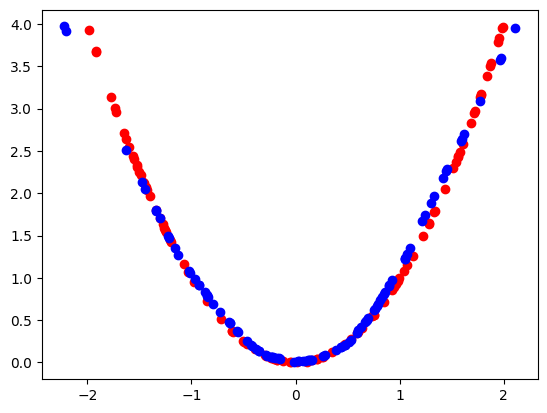

2000 0.45 0.51


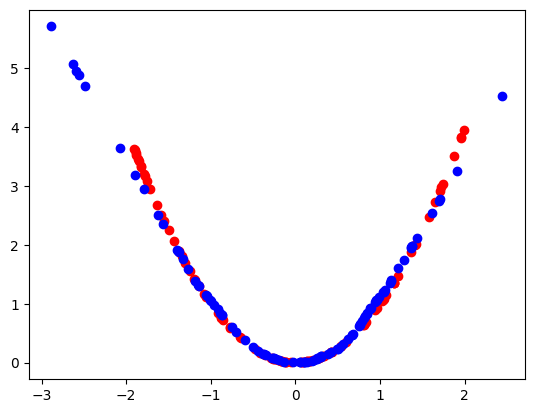

In [10]:
latent_dim = 1
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

accuracies_real_l1, accuracies_fake_l1, g_losses_l1, d_losses_l1 = train(generator=generator,
                                                                         discriminator=discriminator,
                                                                         gan_model=gan_model,
                                                                         latent_dim=latent_dim,
                                                                         n_epochs=2000,
                                                                         n_batch=1024,
                                                                         n_eval=250)


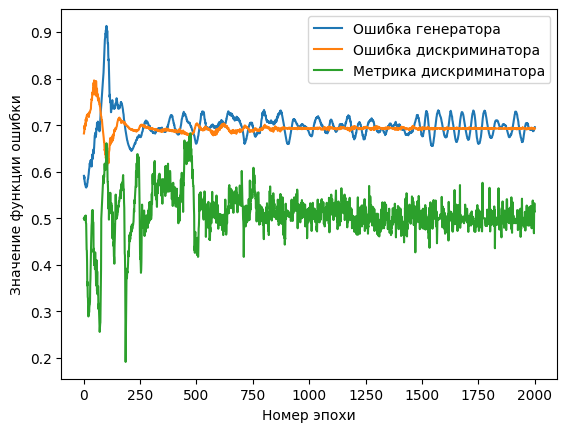

In [11]:
import matplotlib.pyplot as plt

x = range(1, len(accuracies_real_l1) + 1)

plt.plot(x, g_losses_l1, label='Ошибка генератора')
plt.plot(x, np.array(d_losses_l1)[:, :1], label='Ошибка дискриминатора')
plt.plot(x, np.array(d_losses_l1)[:, 1:], label='Метрика дискриминатора')

plt.xlabel('Номер эпохи')
plt.ylabel('Значение функции ошибки')
plt.legend()

plt.show()


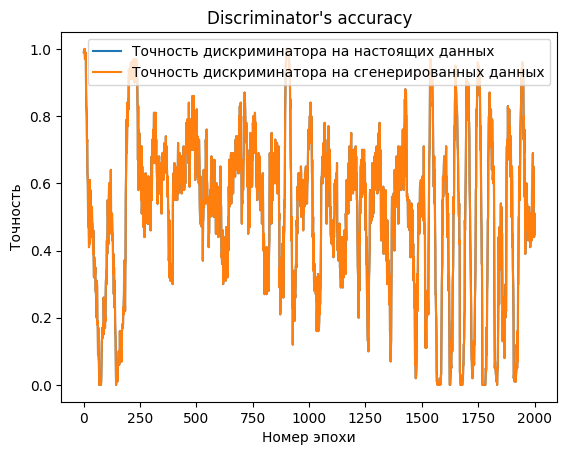

In [12]:
plt.plot(x, accuracies_real_l1, label='Точность дискриминатора на настоящих данных')
plt.plot(x, accuracies_fake_l1, label='Точность дискриминатора на сгенерированных данных')

plt.xlabel('Номер эпохи')
plt.ylabel('Точность')
plt.title("Discriminator's accuracy")
plt.legend()

plt.show()


# Эксперименты с шумом

In [13]:
uniform_distrib = np.array([x/1000 for x in range(-2000, 2001)])
predictions = generator.predict(uniform_distrib.reshape(4001, 1), verbose=0)


In [14]:
predictions


array([[ 1.8682715,  3.1559563],
       [ 1.8675379,  3.1542015],
       [ 1.8668033,  3.1524463],
       ...,
       [-2.629839 ,  5.061584 ],
       [-2.6310549,  5.064669 ],
       [-2.6322713,  5.0677543]], dtype=float32)

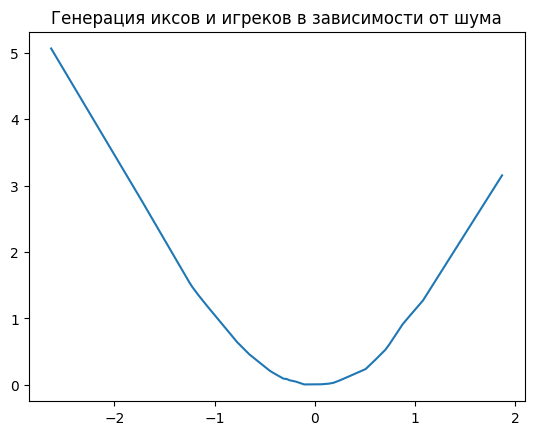

In [15]:
plt.plot(predictions[:, :1], predictions[:, 1:])
plt.title("Генерация иксов и игреков в зависимости от шума")
plt.show()


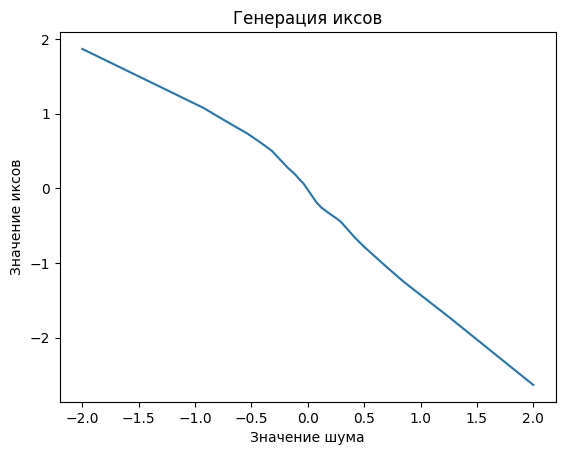

In [16]:
plt.plot(uniform_distrib.reshape(4001, 1), predictions[:, :1])
plt.title("Генерация иксов")
plt.xlabel("Значение шума")
plt.ylabel("Значение иксов")
plt.show()


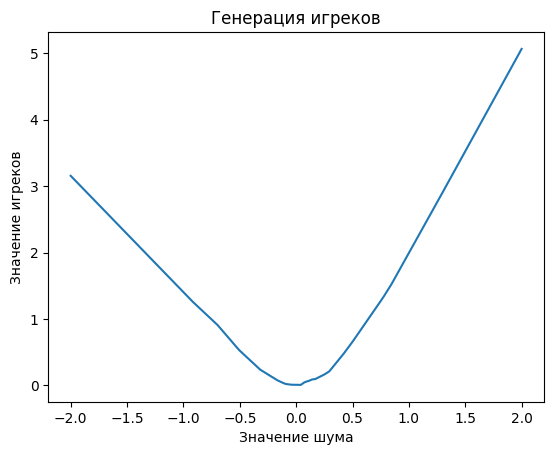

In [17]:
plt.plot(uniform_distrib.reshape(4001, 1), predictions[:, 1:])
plt.title("Генерация игреков")
plt.xlabel("Значение шума")
plt.ylabel("Значение игреков")
plt.show()


# Эксперименты с размерностью скрытого пространства

0 0.49 0.23


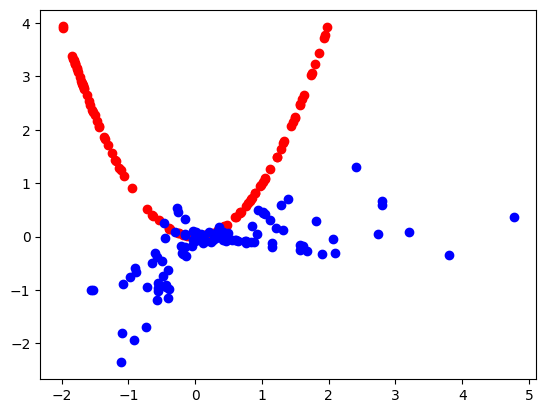

250 0.63 0.0


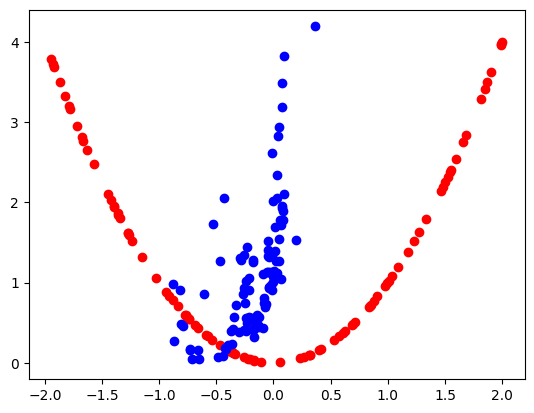

500 0.32 0.92


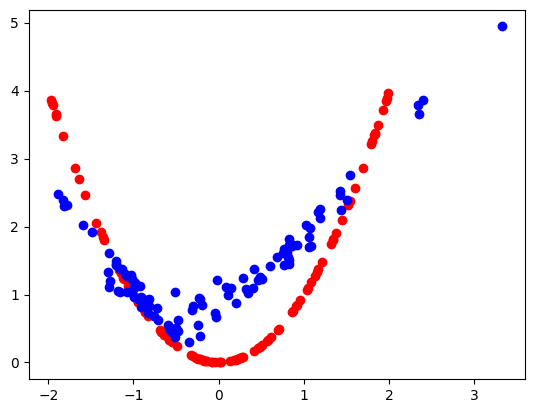

750 0.49 0.61


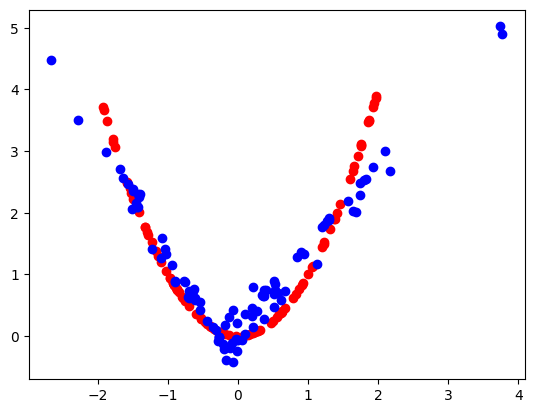

1000 0.42 0.63


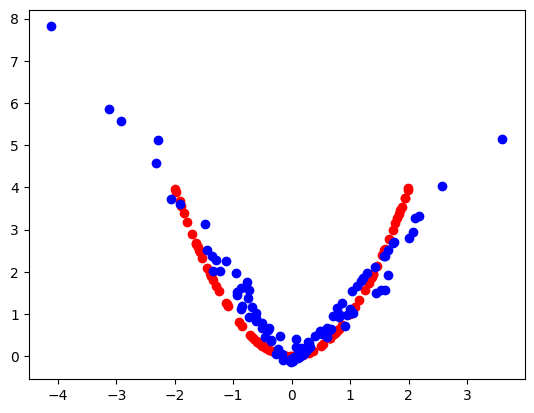

1250 0.5 0.62


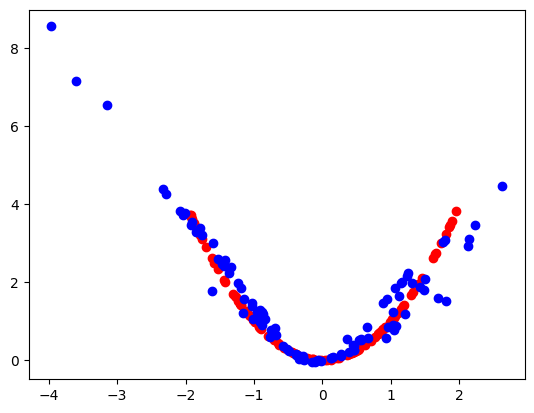

1500 0.31 0.71


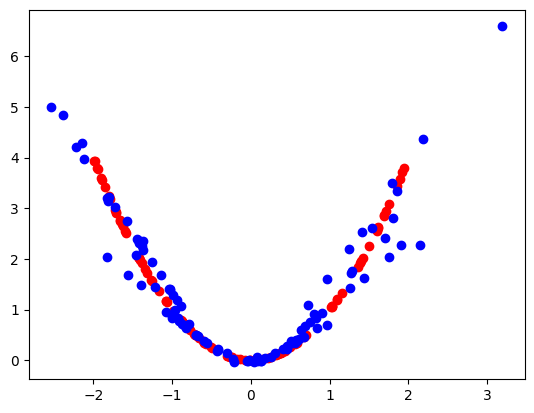

1750 0.55 0.46


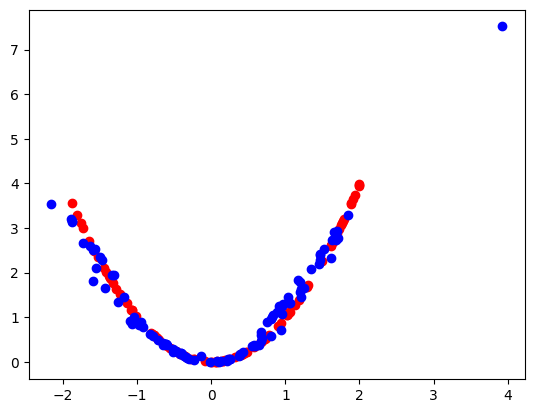

2000 0.09 0.77


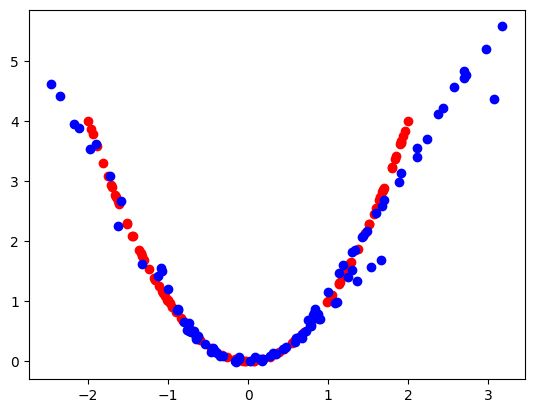

2250 0.48 0.62


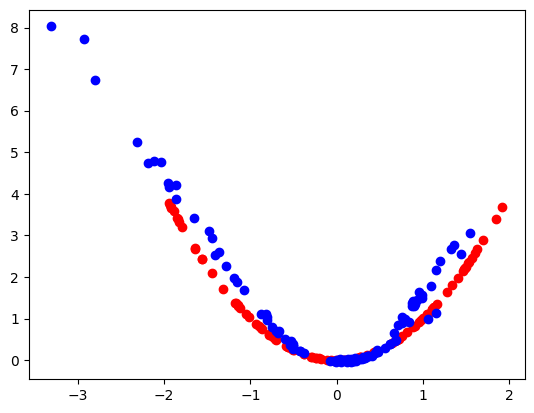

2500 0.42 0.54


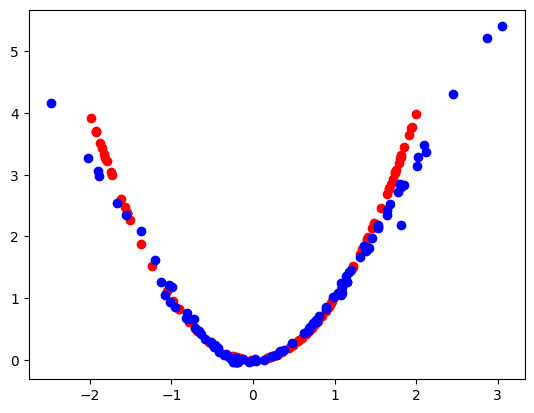

2750 0.32 0.69


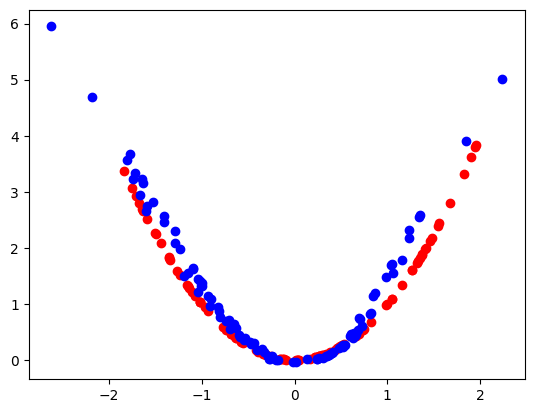

3000 0.61 0.44


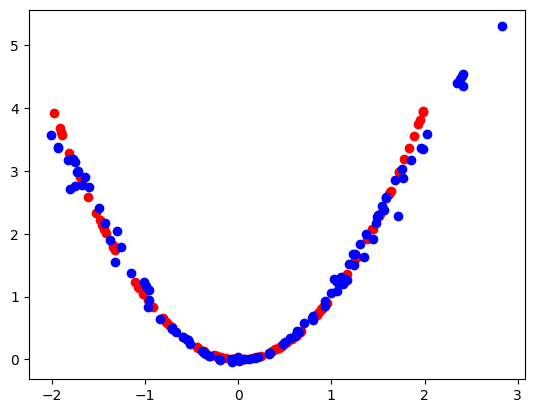

In [18]:
# Теперь уже размерность скрытого пространства будет 2!
latent_dim = 2
discriminator_l2 = define_discriminator()
generator_l2 = define_generator(latent_dim)
gan_model_l2 = define_gan(generator_l2, discriminator_l2)

accuracies_real_l2, accuracies_fake_l2, g_losses_l2, d_losses_l2 = train(generator=generator_l2,
                                                                         discriminator=discriminator_l2,
                                                                         gan_model=gan_model_l2,
                                                                         latent_dim=latent_dim,
                                                                         n_epochs=3000,
                                                                         n_batch=1024,
                                                                         n_eval=250)


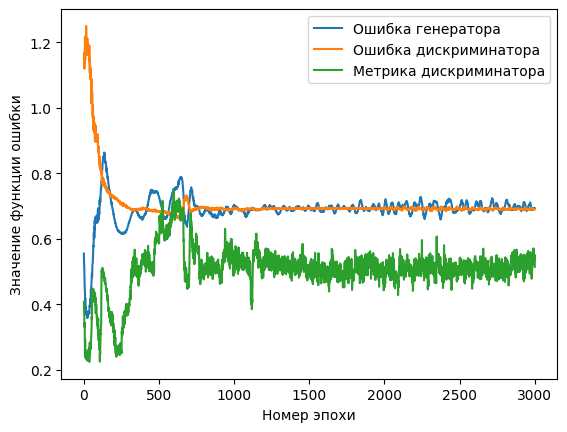

In [19]:
import matplotlib.pyplot as plt

x = range(1, len(accuracies_real_l2) + 1)

plt.plot(x, g_losses_l2, label='Ошибка генератора')
plt.plot(x, np.array(d_losses_l2)[:, :1], label='Ошибка дискриминатора')
plt.plot(x, np.array(d_losses_l2)[:, 1:], label='Метрика дискриминатора')

plt.xlabel('Номер эпохи')
plt.ylabel('Значение функции ошибки')
plt.legend()

plt.show()


# Посмотрим, какие точки дискриминатор вообще считает реальными, а какие фейками

In [20]:
import pandas as pd

xs = np.linspace(-2.5, 2.5, num=100)
ys = np.linspace(-0.5, 4.5, num=100)

x_grid, y_grid = np.meshgrid(xs, ys)

discriminator_environment = pd.DataFrame({'X': x_grid.flatten(), 'Y': y_grid.flatten()})


In [21]:
discriminator_environment['prediction'] = np.array(discriminator_l2.predict(np.array(discriminator_environment[['X', 'Y']]))>=0.5, dtype=int)

313/313 [==============================] - 0s 1ms/step


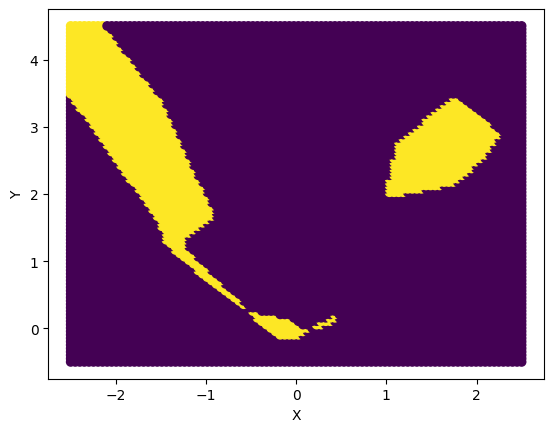

In [22]:
plt.scatter(discriminator_environment['X'],
            discriminator_environment['Y'],
            c=discriminator_environment['prediction'])

plt.xlabel('X')
plt.ylabel('Y')
plt.show()


![title](../pics/scratch.png)

# Порог не обязательно 0.5!

In [23]:
discriminator_environment['prediction'] = np.array(discriminator_l2.predict(np.array(discriminator_environment[['X', 'Y']]))>=0.48, dtype=int)

313/313 [==============================] - 0s 1ms/step


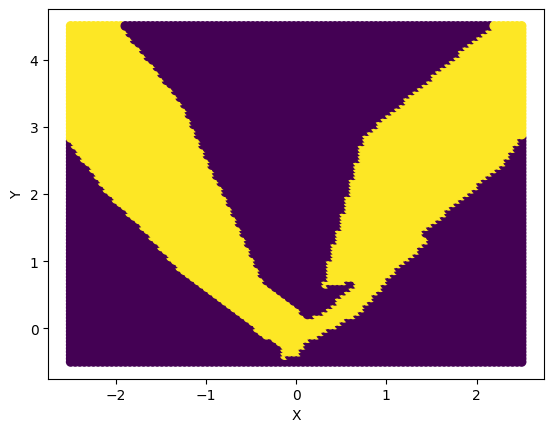

In [24]:
# Вот это уже больше похоже на правду!
plt.scatter(discriminator_environment['X'],
            discriminator_environment['Y'],
            c=discriminator_environment['prediction'])

plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# А если обратиться к дискриминатору, где размерность латентного пространства была поменьше?

In [25]:
discriminator_environment['prediction'] = np.array(discriminator.predict(np.array(discriminator_environment[['X', 'Y']]))>=0.475, dtype=int)

313/313 [==============================] - 0s 988us/step


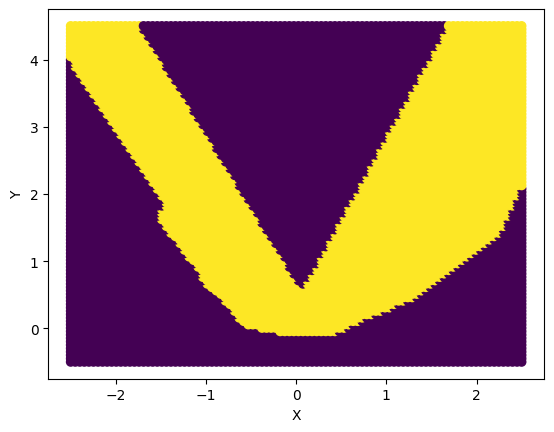

In [26]:
plt.scatter(discriminator_environment['X'],
            discriminator_environment['Y'],
            c=discriminator_environment['prediction'])

plt.xlabel('X')
plt.ylabel('Y')
plt.show()


## Посмотрим на генерации в зависимости от первого шума

In [27]:
# noise_l2_1 = np.vstack([np.array([x/1000 for x in range(-2000, 2001)]), np.array([x/1000 for x in range(-2000, 2001)])]).T
noise_l2_1 = np.vstack([np.array([x/1000 for x in range(-2000, 2001)]), np.array(4 * rand(4001) - 2)]).T
noise_l2_2 = np.vstack([np.array(4 * rand(4001) - 2), np.array([x/1000 for x in range(-2000, 2001)]),]).T
display(noise_l2_1.shape)
display(noise_l2_1)
display(noise_l2_2)


(4001, 2)

array([[-2.        ,  0.85495675],
       [-1.999     , -0.91852735],
       [-1.998     , -1.4060662 ],
       ...,
       [ 1.998     , -1.49961809],
       [ 1.999     ,  0.92679743],
       [ 2.        , -1.3895833 ]])

array([[ 1.00847166, -2.        ],
       [-1.51424248, -1.999     ],
       [-0.44964819, -1.998     ],
       ...,
       [ 1.03842804,  1.998     ],
       [ 1.38310923,  1.999     ],
       [-1.52011511,  2.        ]])

In [28]:
predictions_1 = generator_l2.predict(noise_l2_1, verbose=0)

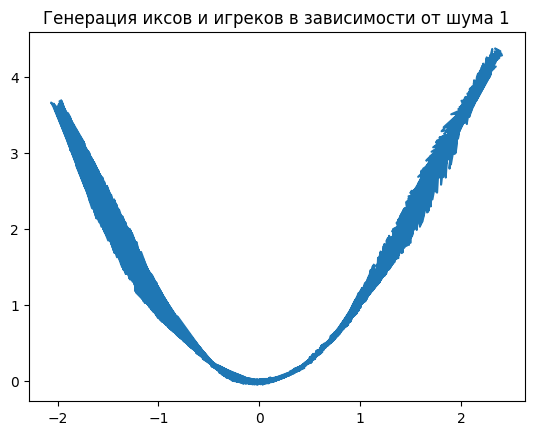

In [29]:
plt.plot(predictions_1[:, :1], predictions_1[:, 1:])
plt.title("Генерация иксов и игреков в зависимости от шума 1")
plt.show()


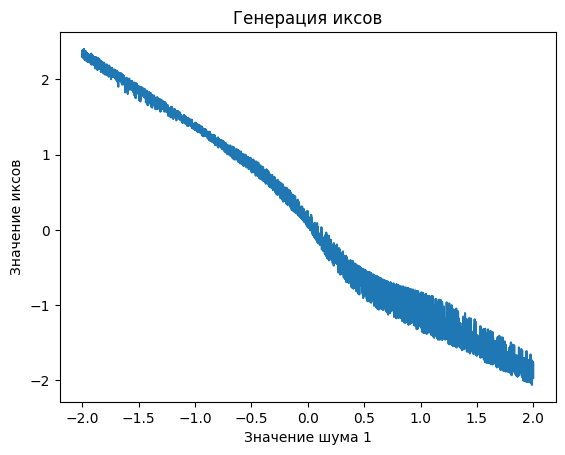

In [30]:
plt.plot(noise_l2_1[:, :1], predictions_1[:, :1])
plt.title("Генерация иксов")
plt.xlabel("Значение шума 1")
plt.ylabel("Значение иксов")
plt.show()


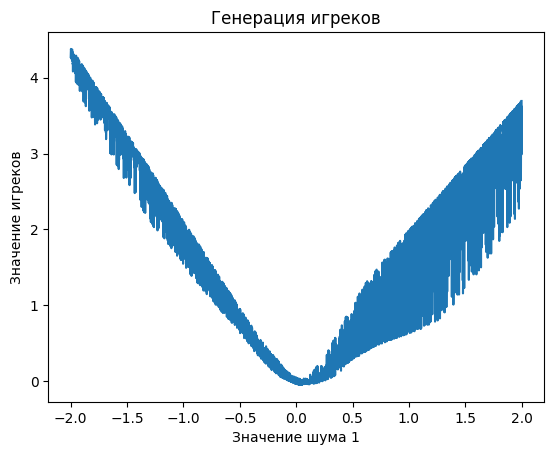

In [31]:
plt.plot(noise_l2_1[:, :1], predictions_1[:, 1:])
plt.title("Генерация игреков")
plt.xlabel("Значение шума 1")
plt.ylabel("Значение игреков")
plt.show()


## Посмотрим на генерации в зависимости от второго шума

In [32]:
predictions_2 = generator_l2.predict(noise_l2_2, verbose=0)

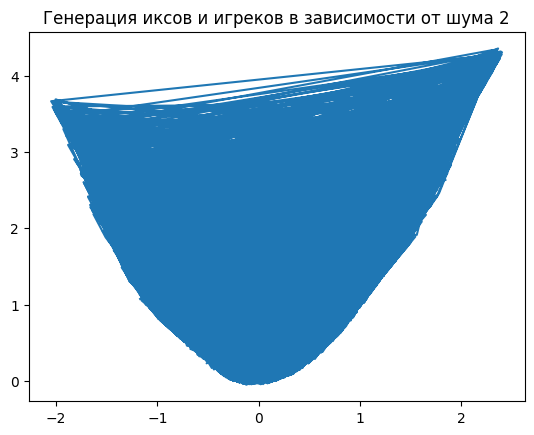

In [33]:
plt.plot(predictions_2[:, :1], predictions_2[:, 1:])
plt.title("Генерация иксов и игреков в зависимости от шума 2")
plt.show()


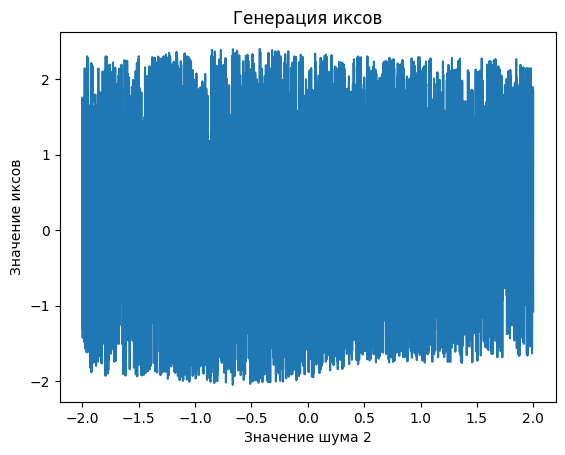

In [34]:
plt.plot(noise_l2_2[:, 1:], predictions_2[:, :1])
plt.title("Генерация иксов")
plt.xlabel("Значение шума 2")
plt.ylabel("Значение иксов")
plt.show()


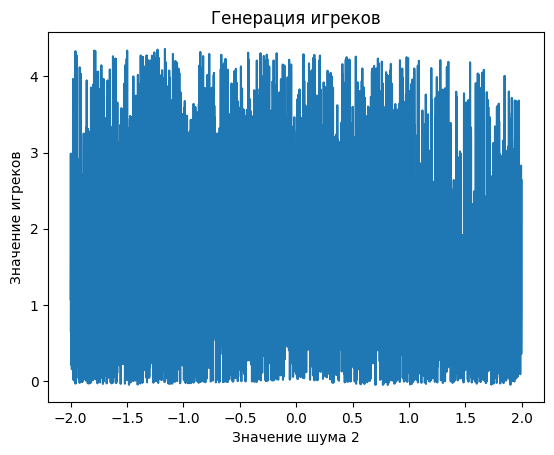

In [35]:
plt.plot(noise_l2_2[:, 1:], predictions_2[:, 1:])
plt.title("Генерация игреков")
plt.xlabel("Значение шума 2")
plt.ylabel("Значение игреков")
plt.show()


## Получается, что второй шум избыточен и почти не играет роли? Проверим!

### Возьмем много точек из латентного пространства, а потом посмотрим, как хорошо 'хорошие' фейки отличаются от 'плохих' в латентном пространстве.
Под 'хорошими' фейками я подразумеваю хорошо сгенерированные данные, которые дискриминатор помечает реальными. 'Плохие' фейки - те, которые дискириминатор отметил как сгенерированные.

In [36]:
big_noise = np.vstack([np.array(4 * rand(2000) - 2), np.array(4 * rand(2000) - 2)]).T
big_noise_pd = pd.DataFrame(big_noise, columns=['noise_1', 'noise_2'])


In [37]:
predictions = gan_model_l2(big_noise)
predictions = np.array(predictions >= 0.5, dtype=int)
big_noise_pd['prediction'] = predictions


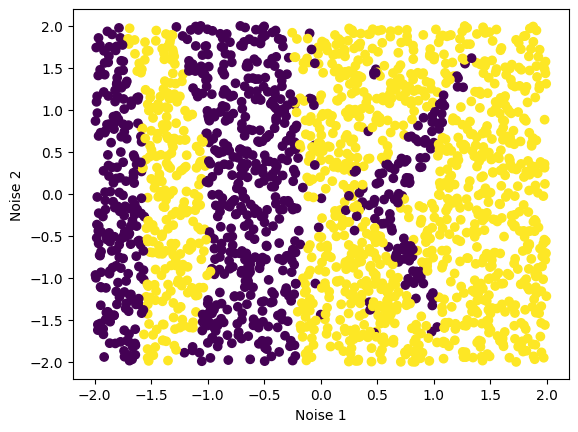

In [38]:
# Похоже на то, что второй шум действительно маловажен!
plt.scatter(big_noise_pd['noise_1'],
            big_noise_pd['noise_2'],
            c=big_noise_pd['prediction'])

plt.xlabel('Noise 1')
plt.ylabel('Noise 2')
plt.show()


# Хочу посмотреть, какой путь проходит сгенерированная точка, пока я перехожу из одной точки латентного пространства в другую

## Для начала напишем функцию, которая будет строить прямую (по которой будем двигаться) по двум координатам.

In [39]:
def interpolation_line(coord_1, coord_2, n):
    x_1 = coord_1[0]
    y_1 = coord_1[1]
    x_2 = coord_2[0]
    y_2 = coord_2[1]

    xs = np.linspace(x_1, x_2, num=n)
    ys = np.linspace(y_1, y_2, num=n)

    return np.vstack([xs, ys]).T
    

# Бежим по латентному пространству и отображаем сгенерированный результат на графике

In [40]:
line = interpolation_line((-0.75, 1), (1.5, 0), 100)
predictions = generator_l2.predict(line, verbose=0)


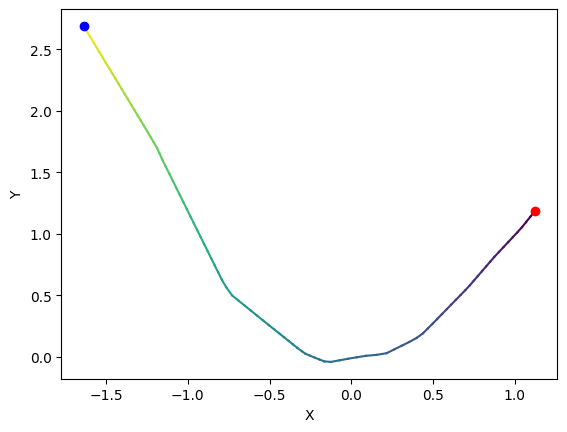

In [41]:
length = predictions.shape[0]

colors = np.linspace(0, 1, length)
cmap = plt.get_cmap('viridis')

for i in range(length - 1):
    plt.plot(predictions[i:i+2, :1], predictions[i:i+2, 1:], color=cmap(colors[i]))

plt.scatter(predictions[0, :1], predictions[0, 1:], color='red', label='First Point', zorder=5)
plt.scatter(predictions[-1, :1], predictions[-1, 1:], color='blue', label='Last Point', zorder=5)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# И еще один пример

In [42]:
line = interpolation_line((1.5, 1), (1.7, -2), 100)
predictions = generator_l2.predict(line, verbose=0)


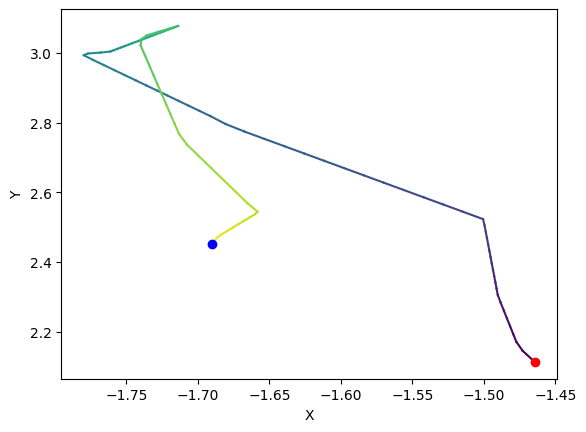

In [43]:
length = predictions.shape[0]

colors = np.linspace(0, 1, length)
cmap = plt.get_cmap('viridis')

for i in range(length - 1):
    plt.plot(predictions[i:i+2, :1], predictions[i:i+2, 1:], color=cmap(colors[i]))

plt.scatter(predictions[0, :1], predictions[0, 1:], color='red', label='First Point', zorder=5)
plt.scatter(predictions[-1, :1], predictions[-1, 1:], color='blue', label='Last Point', zorder=5)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()
